In [138]:
import numpy as np
import SimpleITK as sitk
import os
import torch
import matplotlib.pyplot as plt
from utils.visualization import *
from utils import general
from models import models
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import torch.nn.functional as F


# set cuda visible devices
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

ted2camus_path = '/home/mtarufo/thesis/supervision_by_registration/data/ted2camus.csv'
ted2camus = pd.read_csv(ted2camus_path)

index = 5
ted_id = ted2camus.iloc[index]['ted_id']
camus_id = ted2camus.iloc[index]['camus_id']
view = '4CH'

print(ted2camus)
print(f'\nChosen patients: TED {ted_id}, CAMUS {camus_id}')

    ted_id  camus_id
0        1         2
1        2         4
2        3         5
3        4         8
4        5        10
..     ...       ...
89      93       145
90      94       146
91      95       147
92      96       148
93      97       152

[94 rows x 2 columns]

Chosen patients: TED 6, CAMUS 12


In [139]:
# Import CAMUS video
vid_path = f'/home/mtarufo/thesis/supervision_by_registration/data/camus/training/patient{camus_id:04d}/patient{camus_id:04d}_{view}_sequence.mhd'
vid = sitk.ReadImage(vid_path)
vid = sitk.GetArrayFromImage(vid)
print(f'CAMUS: patient{camus_id:04d} ({view})\nVideo shape: {vid.shape}')

first_mask_path = f'/home/mtarufo/thesis/supervision_by_registration/data/camus/training/patient{camus_id:04d}/patient{camus_id:04d}_{view}_ED_gt.mhd'
first_mask = sitk.ReadImage(first_mask_path)
first_mask = sitk.GetArrayFromImage(first_mask)[0]
print(f'\nFirst mask shape: {first_mask.shape}')

last_mask_path = f'/home/mtarufo/thesis/supervision_by_registration/data/camus/training/patient{camus_id:04d}/patient{camus_id:04d}_{view}_ES_gt.mhd'
last_mask = sitk.ReadImage(last_mask_path)
last_mask = sitk.GetArrayFromImage(last_mask)[0]
print(f'Last mask shape: {last_mask.shape}')

cnn_propagated_masks_path = f'/home/mtarufo/thesis/supervision_by_registration/data/camus/training/patient{camus_id:04d}/patient{camus_id:04d}_{view}_sequence_gt.mhd'
cnn_propagated_masks_tmp = sitk.ReadImage(cnn_propagated_masks_path)
cnn_propagated_masks_tmp = sitk.GetArrayFromImage(cnn_propagated_masks_tmp)
print(f'\nCNN propagated masks shape: {cnn_propagated_masks_tmp.shape}')

# resize to original size
cnn_propagated_masks = F.interpolate(torch.from_numpy(cnn_propagated_masks_tmp).unsqueeze(1).float(), size=vid.shape[1:], mode='nearest-exact').squeeze().numpy()
print(f'CNN processed masks shape: {cnn_propagated_masks.shape}')

# Import TED video
gt_path = sitk.ReadImage(f'/home/mtarufo/thesis/supervision_by_registration/data/ted/database/patient{ted_id:03d}/patient{ted_id:03d}_{view}_sequence_gt.mhd')
gt = sitk.GetArrayFromImage(gt_path)
gt = gt[0:vid.shape[0],:,:] # crop to the same size as CAMUS
print(f'\nTED: patient{ted_id:03d} ({view})\nVideo shape: {gt.shape}')

CAMUS: patient0012 (4CH)
Video shape: (22, 843, 512)

First mask shape: (843, 512)
Last mask shape: (843, 512)

CNN propagated masks shape: (22, 512, 512)
CNN processed masks shape: (22, 843, 512)

TED: patient006 (4CH)
Video shape: (22, 843, 512)


In [146]:
out_dir = "prova"

kwargs = {}
kwargs["verbose"] = False
kwargs["save_model"] = False
# kwargs["save_folder"] = os.path.join(out_dir, camus_id + '_' + view)

kwargs["jacobian_regularization"] = True
kwargs["alpha_jacobian"] = 1 # default is 0.05

kwargs["bending_regularization"] = True
kwargs["alpha_bending"] = 10 # default is 10

kwargs["network_type"] = "SIREN"  # Options are "MLP" and "SIREN"

# make a binary map where moving_img > 10
mask = vid[0] > 10

kwargs["mask"] = mask
kwargs["batch_size"] = 4000
kwargs["omega"] = 64
kwargs["epochs"] = 250

outname = f'alphaJacob_{kwargs["alpha_jacobian"]}_alphaBend_{kwargs["alpha_bending"]}_omega_{kwargs["omega"]}_epochs_{kwargs["epochs"]}_batch_size_{kwargs["batch_size"]}'


In [147]:
def interpolate_masks(warped_masks_forward, warped_masks_backward):
    """
    Aggregate the forward and backward warped masks using a distance transform, as seen in https://stackoverflow.com/questions/51409818/how-to-average-two-masks.
    Args:
        warped_masks_forward: Forward warped masks of shape [T,H,W]
        warped_masks_backward: Backward warped masks of shape [T,H,W]
    Returns:
        warped_interpolated_masks: Interpolated masks of shape [T,H,W]
    """

    # Initialize output
    warped_interpolated_masks = np.zeros_like(warped_masks_forward)
    # Initialize kernel to be used for closing
    kernel = np.ones((5, 5), np.uint8)
    # Initialize weights
    t = np.linspace(0, np.pi/2, warped_masks_forward.shape[0])
    
    for i, (frame_mask_forward, frame_mask_backward) in enumerate(zip(warped_masks_forward, warped_masks_backward)):
        # Initialize per-frame mask container
        mask = np.zeros((4, warped_masks_forward.shape[1], warped_masks_forward.shape[2]))
        
        # Loop over the different classes
        for j in [0,1,2,3]:

            # Extract binary mask 
            binary_forward = (frame_mask_forward == j)
            binary_backward = (frame_mask_backward == j)

            # Compute distance transform
            d1 = cv2.distanceTransform(binary_forward.astype(np.uint8), cv2.DIST_L2, 3) - cv2.distanceTransform((~binary_forward).astype(np.uint8), cv2.DIST_L2, 3)
            d2 = cv2.distanceTransform(binary_backward.astype(np.uint8), cv2.DIST_L2, 3) - cv2.distanceTransform((~binary_backward).astype(np.uint8), cv2.DIST_L2, 3)
            mask[j] = (d1 * np.cos(t[i])**2 + d2 * np.sin(t[i])**2) > 0
        
        # Merge individual masks
        merged_mask = np.argmax(mask, axis=0).astype(np.uint8)
        # Close holes and gaps in the masks using a morphological operation
        warped_interpolated_masks[i] = cv2.morphologyEx(merged_mask, cv2.MORPH_CLOSE, kernel)

    return warped_interpolated_masks

def propagate_mask(vid, mask):

    propagated_masks = np.zeros_like(vid)
    propagated_masks[0] = mask

    for i in tqdm(range(vid.shape[0]-1)):
        moving_img = torch.FloatTensor(vid[i])
        fixed_img = torch.FloatTensor(vid[i+1])

        ImpReg = models.ImplicitRegistrator(moving_img, fixed_img, **kwargs)
        ImpReg.fit()
        
        propagated_masks[i+1] = ImpReg(torch.FloatTensor(propagated_masks[i]), fast=False, return_dvf=False, ftype='mask')

    return propagated_masks

print('Propagating mask in the forward direction...')
forward_propagation = propagate_mask(vid, first_mask)

print('Propagating mask in the backward direction...')
backward_propagation = propagate_mask(np.flip(vid, axis=0), last_mask)

print('Interpolating masks....')
propagated_masks = interpolate_masks(forward_propagation, np.flip(backward_propagation, axis=0))

Propagating mask in the forward direction...


  0%|          | 0/21 [00:00<?, ?it/s]

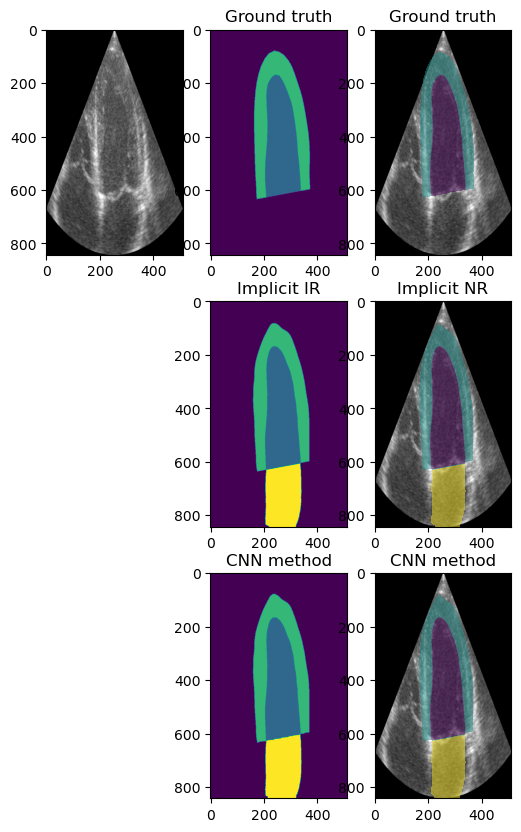

In [ ]:
import numpy as np
import SimpleITK as sitk
from matplotlib import animation
from matplotlib.animation import FuncAnimation

# Create the figure and axis objects
fig, ax = plt.subplots(3,3, figsize=(6, 10))

im_vid = ax[0,0].imshow(vid[0], cmap='gray')
gt_tmp = gt[0].copy()
gt_tmp[0,0] = 3
im_gt1 = ax[0,1].imshow(gt_tmp)
ax[0,1].set_title('Ground truth')
im_gt2_1 = ax[0,2].imshow(vid[0], cmap='gray')
im_gt2_2 = ax[0,2].imshow(np.ma.masked_where(gt_tmp == 0, gt_tmp), alpha=0.5)
ax[0,2].set_title('Ground truth')

im_inr1 = ax[1,1].imshow(propagated_masks[0])
ax[1,1].set_title('Implicit IR')
im_inr2_1 = ax[1,2].imshow(vid[0], cmap='gray')
im_inr2_2 = ax[1,2].imshow(np.ma.masked_where(propagated_masks[0] == 0, propagated_masks[0]), alpha=0.5)
ax[1,2].set_title('Implicit NR')

im_cnn1 = ax[2,1].imshow(cnn_propagated_masks[0])
ax[2,1].set_title('CNN method')
im_cnn2_1 = ax[2,2].imshow(vid[0], cmap='gray')
im_cnn2_2 = ax[2,2].imshow(np.ma.masked_where(cnn_propagated_masks[0] == 0, cnn_propagated_masks[0]), alpha=0.5)
ax[2,2].set_title('CNN method')

# hide axis for ax[1,0]
ax[1,0].axis('off')
ax[2,0].axis('off')


# Define the update function for the animation
def update(frame):
    im_vid.set_data(vid[frame])
    im_gt1.set_data(gt[frame])
    im_gt2_1.set_data(vid[frame])
    im_gt2_2.set_data(np.ma.masked_where(gt[frame] == 0, gt[frame]))
    im_inr1.set_data(propagated_masks[frame])
    im_inr2_1.set_data(vid[frame])
    im_inr2_2.set_data(np.ma.masked_where(propagated_masks[frame] == 0, propagated_masks[frame]))
    im_cnn1.set_data(cnn_propagated_masks[frame])
    im_cnn2_1.set_data(vid[frame])
    im_cnn2_2.set_data(np.ma.masked_where(cnn_propagated_masks[frame] == 0, cnn_propagated_masks[frame]))

    return (im_vid, im_gt1, im_gt2_1, im_gt2_2, im_inr1, im_inr2_1, im_inr2_2, im_cnn1, im_cnn2_1, im_cnn2_2)

# Create the animation object
anim = FuncAnimation(fig, update, frames=vid.shape[0], interval=50, blit=True)

# Save the animation as an mp4 file
Writer = animation.FFMpegWriter(fps=20, bitrate=1800)
# anim.save(f'./results/animations/{folder_name}_{vid_name}_{view}_chunk{chunk}.mp4', writer=Writer)
anim.save(f'output/{outname}.mp4', writer=Writer)

# Display the animation in the notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

In [133]:
# out_dir = "prova"

# kwargs = {}
# kwargs["verbose"] = True
# kwargs["save_model"] = False
# # kwargs["save_folder"] = os.path.join(out_dir, camus_id + '_' + view)

# kwargs["jacobian_regularization"] = True
# kwargs["alpha_jacobian"] = 0.1 # default is 0.05

# kwargs["bending_regularization"] = True
# kwargs["alpha_bending"] = 0.5 # default is 10

# kwargs["network_type"] = "SIREN"  # Options are "MLP" and "SIREN"

# # make a binary map where moving_img > 10
# mask = vid[0] > 10

# kwargs["mask"] = mask
# kwargs["batch_size"] = 1000
# kwargs["omega"] = 80
# kwargs["epochs"] = 500